In [1]:
import os
import shutil
import gc
from collections import defaultdict
from typing import Tuple, List
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import polars as pl
import pydicom
from scipy import ndimage
from sklearn.preprocessing import StandardScaler
import random
import matplotlib.pyplot as plt


import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

import kaggle_evaluation.rsna_inference_server

In [2]:
if torch.cuda.is_available:
    DEVICE='cuda'
else:
    DEVICE='cpu'

In [3]:
DEVICE

'cuda'

In [4]:
# -----------------------
# Config 
# -----------------------
SERIES_DIR = "/kaggle/input/rsna-intracranial-aneurysm-detection/series"  # path to series folders, change to yours
TRAIN_CSV = "/kaggle/input/rsna-intracranial-aneurysm-detection/train.csv"  # path to training csv, change to yours
OUTPUT_MODEL = "model_weights.pth"

# Training hyperparams 
NUM_EPOCHS = 25
BATCH_SIZE = 16
LR = 1e-3
TARGET_SIZE = (64, 64, 64)  # (D, H, W)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Label columns
LABEL_COLS = [
    'Left Infraclinoid Internal Carotid Artery',
    'Right Infraclinoid Internal Carotid Artery',
    'Left Supraclinoid Internal Carotid Artery',
    'Right Supraclinoid Internal Carotid Artery',
    'Left Middle Cerebral Artery',
    'Right Middle Cerebral Artery',
    'Anterior Communicating Artery',
    'Left Anterior Cerebral Artery',
    'Right Anterior Cerebral Artery',
    'Left Posterior Communicating Artery',
    'Right Posterior Communicating Artery',
    'Basilar Tip',
    'Other Posterior Circulation',
    'Aneurysm Present',
]
NUM_CLASSES = len(LABEL_COLS)

In [5]:
NUM_CLASSES

14

In [6]:
class DICOMProcessor:
    """Robust loader for a DICOM series -> 3D numpy volume."""
    def __init__(self, target_size: Tuple[int,int,int]=TARGET_SIZE):
        self.target_size = target_size

    def load_dicom_series(self, series_path: str) -> np.ndarray:
        """Load DICOM series into 3D numpy array (D, H, W).
           Returns zeros if series_path missing or no valid slices.
        """
        if not os.path.exists(series_path):
            # fallback: generate zeros
            return np.zeros(self.target_size, dtype=np.float32)

        # collect files ending with .dcm or all files
        dicom_files = []
        for root, _, files in os.walk(series_path):
            for fname in files:
                if fname.lower().endswith('.dcm') or fname.lower().endswith('.ima'):
                    dicom_files.append(os.path.join(root, fname))
        if not dicom_files:
            # try all files in directory
            all_files = [os.path.join(series_path, f) for f in os.listdir(series_path)]
            dicom_files = [f for f in all_files if os.path.isfile(f)]
        if not dicom_files:
            return np.zeros(self.target_size, dtype=np.float32)

        dicoms = []
        for fp in dicom_files:
            try:
                ds = pydicom.dcmread(fp, force=True)
                if hasattr(ds, "PixelData"):
                    # instance number fallback to file order if missing
                    inst = getattr(ds, "InstanceNumber", None)
                    try:
                        inst = int(inst) if inst is not None else None
                    except Exception:
                        inst = None
                    dicoms.append((inst, ds))
            except Exception:
                continue

        if not dicoms:
            return np.zeros(self.target_size, dtype=np.float32)

        # Sort by instance number where available; else preserve file order
        dicoms_sorted = sorted(dicoms, key=lambda x: (x[0] is None, x[0] if x[0] is not None else 0))
        slices = []
        for _, ds in dicoms_sorted:
            try:
                arr = ds.pixel_array.astype(np.float32)
                # apply rescale if present
                slope = float(getattr(ds, "RescaleSlope", 1.0))
                intercept = float(getattr(ds, "RescaleIntercept", 0.0))
                arr = arr * slope + intercept
                slices.append(arr)
            except Exception:
                continue

        if not slices:
            return np.zeros(self.target_size, dtype=np.float32)

        vol = np.stack(slices, axis=0)  # shape (D, H, W)
        vol = self.preprocess_volume(vol)
        return vol

    def preprocess_volume(self, volume):
        # Ensure shape is (D, H, W)
        if volume.ndim == 4:
            volume = np.squeeze(volume)
        elif volume.ndim == 2:
            volume = np.expand_dims(volume, axis=0)
    
        # Clip + normalize
        vmin, vmax = np.percentile(volume, (1, 99))
        volume = np.clip(volume, vmin, vmax)
        volume = (volume - vmin) / (vmax - vmin + 1e-8)
    
        # Resize
        if volume.shape != self.target_size:
            while len(volume.shape) < 3:
                volume = np.expand_dims(volume, axis=0)
            zoom_factors = [self.target_size[i] / volume.shape[i] for i in range(3)]
            volume = ndimage.zoom(volume, zoom_factors, order=1)
    
        return volume.astype(np.float32)

class VolumePreprocessor:
    """Preprocessing + augmentation for training/inference."""
    def __init__(self, target_size=TARGET_SIZE, is_training=True):
        self.target_size = target_size
        self.is_training = is_training

    def preprocess(self, volume: np.ndarray) -> np.ndarray:
        # volume assumed normalized [0,1] and resized already by DICOMProcessor
        vol = volume.copy().astype(np.float32)
        if self.is_training:
            vol = self.augment(vol)
        # final safety clip
        vol = np.clip(vol, 0.0, 1.0)
        return vol

    def augment(self, vol: np.ndarray) -> np.ndarray:
        # random flips
        if random.random() < 0.5:
            if random.random() < 0.5:
                vol = np.flip(vol, axis=1)  # H
            if random.random() < 0.5:
                vol = np.flip(vol, axis=2)  # W
            if random.random() < 0.5:
                vol = np.flip(vol, axis=0)  # D
            vol = vol.copy()

        # small rotation
        if random.random() < 0.3:
            angle = random.uniform(-10, 10)
            axes = random.choice([(1,2), (0,1), (0,2)])
            vol = ndimage.rotate(vol, angle, axes=axes, reshape=False, order=1, mode='nearest')

        # intensity jitter
        if random.random() < 0.3:
            scale = random.uniform(0.9, 1.1)
            shift = random.uniform(-0.05, 0.05)
            vol = vol * scale + shift

        # gaussian noise
        if random.random() < 0.2:
            vol = vol + np.random.normal(0, 0.02, size=vol.shape)

        # zoom
        if random.random() < 0.2:
            zf = random.uniform(0.9, 1.1)
            vol = ndimage.zoom(vol, zf, order=1)
            # center-crop or pad back to target
            vol = self._crop_or_pad(vol, self.target_size)

        return vol

    def _crop_or_pad(self, arr, target_shape):
        out = np.zeros(target_shape, dtype=np.float32)
        d_min = min(arr.shape[0], target_shape[0])
        h_min = min(arr.shape[1], target_shape[1])
        w_min = min(arr.shape[2], target_shape[2])
        d0 = (target_shape[0] - d_min) // 2
        h0 = (target_shape[1] - h_min) // 2
        w0 = (target_shape[2] - w_min) // 2
        # crop center of arr
        sd = (arr.shape[0] - d_min) // 2
        sh = (arr.shape[1] - h_min) // 2
        sw = (arr.shape[2] - w_min) // 2
        out[d0:d0+d_min, h0:h0+h_min, w0:w0+w_min] = arr[sd:sd+d_min, sh:sh+h_min, sw:sw+w_min]
        return out

In [7]:
class Simple3DCNN(nn.Module):
    def __init__(self, num_classes=NUM_CLASSES):
        super().__init__()
        self.conv1 = nn.Conv3d(1, 16, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm3d(16)
        self.pool1 = nn.MaxPool3d(2)

        self.conv2 = nn.Conv3d(16, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm3d(32)
        self.pool2 = nn.MaxPool3d(2)

        self.conv3 = nn.Conv3d(32, 64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm3d(64)
        self.pool3 = nn.MaxPool3d(2)

        self.conv4 = nn.Conv3d(64, 128, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm3d(128)
        self.pool4 = nn.MaxPool3d(2)

        self.adaptive_pool = nn.AdaptiveAvgPool3d((2,2,2))
        self.fc1 = nn.Linear(128 * 2 * 2 * 2, 256)
        self.drop1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, 128)
        self.drop2 = nn.Dropout(0.3)
        self.fc3 = nn.Linear(128, num_classes)

    def forward(self, x):
        # x: (B, 1, D, H, W)
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool1(x)
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool2(x)
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool3(x)
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool4(x)
        x = self.adaptive_pool(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.drop1(x)
        x = F.relu(self.fc2(x))
        x = self.drop2(x)
        x = self.fc3(x)
        return x  

In [8]:
class AneurysmDataset(Dataset):
    def __init__(self, df: pd.DataFrame, series_dir: str, dicom_processor: DICOMProcessor, preprocessor: VolumePreprocessor, is_training=True):
        self.df = df.reset_index(drop=True)
        self.series_dir = series_dir
        self.dp = dicom_processor
        self.pre = preprocessor
        self.is_training = is_training

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        series_id = str(row.get('SeriesInstanceUID', row.get('series_id', 'missing_series')))
        series_path = os.path.join(self.series_dir, series_id)

        vol = self.dp.load_dicom_series(series_path)  # already resized & normalized to [0,1]
        vol = self.pre.preprocess(vol)  # augment only in training

        # Ensure shape and dtype
        vol = vol.astype(np.float32)
        # Add channel dim
        vol_tensor = torch.from_numpy(vol).unsqueeze(0)  # (1, D, H, W)

        # Labels: if present in df, else zeros (useful for synthetic demo)
        if all(col in self.df.columns for col in LABEL_COLS):
            labels = row[LABEL_COLS].values.astype(np.float32)
        else:
            labels = np.zeros(NUM_CLASSES, dtype=np.float32)
        labels_tensor = torch.from_numpy(labels)

        return vol_tensor, labels_tensor

In [9]:
def load_or_synthesize_df(csv_path: str, series_dir: str, n_samples=16):
    if os.path.exists(csv_path):
        df = pd.read_csv(csv_path)
        # Keep only rows whose series folder exists when possible
        if 'SeriesInstanceUID' in df.columns:
            df = df.sample(frac=1, random_state=42).reset_index(drop=True)
            # sample down to manageable size if very large
            df = df.head(n_samples)
        return df
    else:
        # synthesize small dataframe for demonstration
        print(f"[Info] TRAIN_CSV not found at {csv_path}. Synthesizing demo dataframe.")
        rows = []
        # make subfolders with random small volumes in SERIES_DIR if needed
        os.makedirs(series_dir, exist_ok=True)
        for i in range(n_samples):
            sid = f"demo_series_{i}"
            folder = os.path.join(series_dir, sid)
            os.makedirs(folder, exist_ok=True)
            # create a tiny fake DICOM-like numpy file for the loader fallback
            # but loader expects .dcm; we will not create actual DICOMs to keep simple.
            # Instead the loader will fallback to zeros; labels will be random.
            label = np.random.randint(0,2,size=NUM_CLASSES)
            row = {'SeriesInstanceUID': sid}
            for j, col in enumerate(LABEL_COLS):
                row[col] = int(label[j])
            rows.append(row)
        return pd.DataFrame(rows)

In [10]:
def train_loop():
    # prepare data
    loss_array=[]
    df = load_or_synthesize_df(TRAIN_CSV, SERIES_DIR, n_samples=32)
    dp = DICOMProcessor(target_size=TARGET_SIZE)
    pre = VolumePreprocessor(target_size=TARGET_SIZE, is_training=True)
    dataset = AneurysmDataset(df, SERIES_DIR, dp, pre, is_training=True)
    dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=False)

    # model, loss, optimizer
    model = Simple3DCNN(num_classes=NUM_CLASSES).to(DEVICE)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=LR, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2, factor=0.5, verbose=True)

    model.train()
    for epoch in range(NUM_EPOCHS):
        print(f"Training in progress.....epoch{epoch+1}")
        running_loss = 0.0
        n_batches = 0
        i=0
        for batch_idx, (volumes, labels) in enumerate(dataloader):
            print(f"epoch:{epoch+1} ; iter:{i}")
            # volumes: (B, 1, D, H, W)
            volumes = volumes.to(DEVICE, dtype=torch.float32)
            labels = labels.to(DEVICE, dtype=torch.float32)

            optimizer.zero_grad()
            outputs = model(volumes)  # logits (B, num_classes)

            # Ensure shapes match
            if outputs.shape != labels.shape:
                # if label shape is (B, num_classes) but outputs is (B, num_classes) — ok
                # else try to expand labels
                if labels.dim() == 1:
                    labels = labels.unsqueeze(1)

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += float(loss.item())
            n_batches += 1

            if (batch_idx + 1) % 10 == 0:
                print(f"Epoch {epoch+1}/{NUM_EPOCHS} Batch {batch_idx+1} Loss {loss.item():.4f}")

            # small memory housekeeping
            del volumes, labels, outputs, loss
            torch.cuda.empty_cache()
            gc.collect()
            i+=1

        avg_loss = running_loss / max(1, n_batches)
        print(f"[Epoch {epoch+1}] avg_loss: {avg_loss:.4f}")
        scheduler.step(avg_loss)
        loss_array.append(avg_loss)

        

        # Save intermediate model
        torch.save(model.state_dict(), f"/kaggle/working/intermediary_model_epoch{epoch+1}.pth")
        print(f"Saved checkpoint: intermediary_model_epoch{epoch+1}.pth")
    
    plt.plot(range(1,NUM_EPOCHS+1),loss_array,label='avg loss')
    plt.xlabel("Epoch")
    plt.ylabel("Avg loss")
    plt.title("Avg loss vs Epoch")
    plt.show()
    # final save
    torch.save(model.state_dict(), OUTPUT_MODEL)
    print(f"Training complete. Model saved to {OUTPUT_MODEL}")

Training in progress.....epoch1
epoch:1 ; iter:0
epoch:1 ; iter:1
[Epoch 1] avg_loss: 0.6119
Saved checkpoint: intermediary_model_epoch1.pth
Training in progress.....epoch2
epoch:2 ; iter:0
epoch:2 ; iter:1
[Epoch 2] avg_loss: 0.3857
Saved checkpoint: intermediary_model_epoch2.pth
Training in progress.....epoch3
epoch:3 ; iter:0
epoch:3 ; iter:1
[Epoch 3] avg_loss: 0.2463
Saved checkpoint: intermediary_model_epoch3.pth
Training in progress.....epoch4
epoch:4 ; iter:0
epoch:4 ; iter:1
[Epoch 4] avg_loss: 0.2194
Saved checkpoint: intermediary_model_epoch4.pth
Training in progress.....epoch5
epoch:5 ; iter:0
epoch:5 ; iter:1
[Epoch 5] avg_loss: 0.2201
Saved checkpoint: intermediary_model_epoch5.pth
Training in progress.....epoch6
epoch:6 ; iter:0
epoch:6 ; iter:1
[Epoch 6] avg_loss: 0.1698
Saved checkpoint: intermediary_model_epoch6.pth
Training in progress.....epoch7
epoch:7 ; iter:0
epoch:7 ; iter:1
[Epoch 7] avg_loss: 0.2218
Saved checkpoint: intermediary_model_epoch7.pth
Training in p

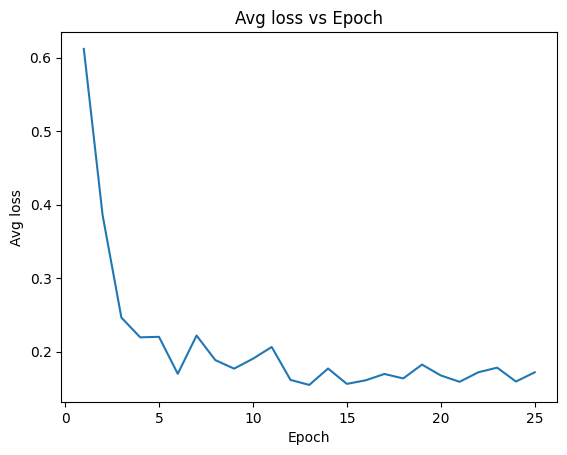

Training complete. Model saved to model_weights.pth


In [11]:
train_loop()

In [12]:
import torch
import polars as pl
import os
import gc
import shutil
import kaggle_evaluation.rsna_inference_server

In [13]:
# ---------------------------
# Config
# ---------------------------
ID_COL = "SeriesInstanceUID"
OUTPUT_MODEL = "model_weights.pth"   # same as used in training
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ---------------------------
# Initialize global model + processor
# ---------------------------
model = None
processor = DICOMProcessor(target_size=(64, 64, 64))  # same as used during training

def initialize_model():
    """Load trained weights once into memory for inference."""
    global model
    if model is None:
        model = Simple3DCNN(num_classes=NUM_CLASSES)
        model.load_state_dict(torch.load(OUTPUT_MODEL, map_location=DEVICE))
        model.to(DEVICE)
        model.eval()
        print("[Info] Model initialized for inference.")

# ---------------------------
# Predict function
# ---------------------------
def predict(series_path: str) -> pl.DataFrame:
    """Run inference for a single DICOM series folder."""

    initialize_model()
    series_id = os.path.basename(series_path)

    try:
        # Load and preprocess DICOM volume
        volume = processor.load_dicom_series(series_path)
        volume = processor.preprocess_volume(volume)

        # Convert to tensor (1,1,D,H,W)
        volume_tensor = torch.from_numpy(volume).unsqueeze(0).unsqueeze(0).float().to(DEVICE)

        # Forward pass
        with torch.no_grad():
            preds = model(volume_tensor)
            preds = torch.sigmoid(preds).cpu().numpy().flatten()

        # Convert to Polars DataFrame (as required by RSNA competition)
        result_data = [[series_id] + preds.tolist()]
        result_df = pl.DataFrame(
            data=result_data,
            schema=[ID_COL] + LABEL_COLS,
            orient="row"
        )

    except Exception as e:
        print(f"[Error] Prediction failed for {series_id}: {e}")
        # fallback neutral output
        result_data = [[series_id] + [0.5] * len(LABEL_COLS)]
        result_df = pl.DataFrame(
            data=result_data,
            schema=[ID_COL] + LABEL_COLS,
            orient="row"
        )

    # Cleanup
    torch.cuda.empty_cache()
    gc.collect()
    shutil.rmtree("/kaggle/shared", ignore_errors=True)

    # RSNA server expects dataframe *without* ID column
    return result_df.drop(ID_COL)

In [14]:
# import polars as pl
# import shutil

# # Ensure shared dir is empty
# shared_dir = "/kaggle/shared"
# shutil.rmtree(shared_dir, ignore_errors=True)
# os.makedirs(shared_dir, exist_ok=True)

# # Reinitialize server with custom label columns
# from kaggle_evaluation import rsna_inference_server

# inference_server = rsna_inference_server.RSNAInferenceServer(predict)

# # Run server
# if os.getenv("KAGGLE_IS_COMPETITION_RERUN"):
#     inference_server.serve()  # Official evaluation
# else:
#     inference_server.run_local_gateway()  # Local test
#     display(pl.read_parquet("/kaggle/working/submission.parquet"))


In [15]:
DEVICE

device(type='cpu')

In [16]:
# Initialize the inference server with our main `predict` function.
initialize_model()

inference_server = kaggle_evaluation.rsna_inference_server.RSNAInferenceServer(predict)

# Check if the notebook is running in the competition environment or a local session.
if os.getenv('KAGGLE_IS_COMPETITION_RERUN'):
    inference_server.serve()
else:
    inference_server.run_local_gateway()
    
    submission_df = pl.read_parquet('/kaggle/working/submission.parquet')
    display(submission_df)

[Info] Model initialized for inference.


SeriesInstanceUID,Left Infraclinoid Internal Carotid Artery,Right Infraclinoid Internal Carotid Artery,Left Supraclinoid Internal Carotid Artery,Right Supraclinoid Internal Carotid Artery,Left Middle Cerebral Artery,Right Middle Cerebral Artery,Anterior Communicating Artery,Left Anterior Cerebral Artery,Right Anterior Cerebral Artery,Left Posterior Communicating Artery,Right Posterior Communicating Artery,Basilar Tip,Other Posterior Circulation,Aneurysm Present
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""1.2.826.0.1.3680043.8.498.1007…",0.000574,0.013593,0.020488,0.003022,0.011395,0.01666,0.017042,0.000647,0.001007,0.000469,0.005124,0.001353,0.038217,0.151938
"""1.2.826.0.1.3680043.8.498.1002…",0.000519,0.012789,0.020593,0.002876,0.01032,0.015918,0.015794,0.000601,0.000882,0.000423,0.00486,0.001243,0.034795,0.159327
"""1.2.826.0.1.3680043.8.498.1005…",0.001151,0.019609,0.029759,0.005532,0.015616,0.024486,0.02349,0.001266,0.00179,0.000972,0.008685,0.002546,0.046838,0.180243
